<a href="https://colab.research.google.com/github/anantoj/covid19-xray-detection/blob/main/notebooks/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# VGG16

In [ ]:
!pip install -Uq tensorflow==2.4

     |████████████████████████████████| 394.7MB 41kB/s 
     |████████████████████████████████| 3.8MB 43.7MB/s 
     |████████████████████████████████| 2.9MB 42.0MB/s 
     |████████████████████████████████| 471kB 40.8MB/s 


In [ ]:
!unzip -q /content/drive/MyDrive/dataset2.zip 

In [ ]:
import os
import random
import shutil
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard,LearningRateScheduler
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 16 
EPOCHS = 50
LEARNING_RATE = 1e-4 
NUM_CLASSES = 2
SPLIT = 0.2
SEED = 42

In [ ]:
random.seed(SEED)
os.chdir('/content/dataset2')
if os.path.isdir('/content/train/covid') is False:
    os.makedirs('/content/train/covid')
    os.makedirs('/content/train/normal')
    os.makedirs('/content/val/covid')
    os.makedirs('/content/val/normal')
    os.makedirs('/content/test/covid')
    os.makedirs('/content/test/normal')

    for c in random.sample(glob.glob('COVID*'), 2892):
        shutil.move(c, '/content/train/covid')
    for c in random.sample(glob.glob('COVID*'), 362):
        shutil.move(c, '/content/val/covid')
    for c in random.sample(glob.glob('COVID*'), 362):
        shutil.move(c, '/content/test/covid')
    for c in random.sample(glob.glob('Normal*'), 8154):
        shutil.move(c, '/content/train/normal')
    for c in random.sample(glob.glob('Normal*'), 1019):
        shutil.move(c, '/content/val/normal')
    for c in random.sample(glob.glob('Normal*'), 1019):
        shutil.move(c, '/content/test/normal')

os.chdir('../')


In [ ]:
train_path = '/content/train'
val_path = '/content/val'
test_path = '/content/test'

In [ ]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 10,
    horizontal_flip = True)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    shuffle=True)

validation_generator = datagen.flow_from_directory(
    val_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    shuffle=True)

test_generator = datagen.flow_from_directory(
    test_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    shuffle=False)

Found 11046 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False) 

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
model_1 = Sequential()
model_1.add(base_model)
model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [ ]:
model_1.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def scheduler(epoch, lr):
      if epoch < 5:
        return lr
      else:
        return lr * tf.math.exp(-0.1)

In [ ]:
log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path='/content/model_1.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [ ]:
hist = model_1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[tensorboard_callback]
)

Epoch 1/50
691/691 [==============================] - 349s 451ms/step - loss: 0.4221 - accuracy: 0.8032 - precision: 0.8013 - recall: 0.8048 - val_loss: 0.1736 - val_accuracy: 0.9319 - val_precision: 0.9325 - val_recall: 0.9305

Epoch 00001: val_accuracy improved from -inf to 0.93193, saving model to /content/model_1.h5
Epoch 2/50
691/691 [==============================] - 305s 441ms/step - loss: 0.2155 - accuracy: 0.9111 - precision: 0.9110 - recall: 0.9113 - val_loss: 0.1330 - val_accuracy: 0.9522 - val_precision: 0.9522 - val_recall: 0.9529

Epoch 00002: val_accuracy improved from 0.93193 to 0.95221, saving model to /content/model_1.h5
Epoch 3/50
691/691 [==============================] - 305s 440ms/step - loss: 0.1791 - accuracy: 0.9320 - precision: 0.9319 - recall: 0.9319 - val_loss: 0.1044 - val_accuracy: 0.9667 - val_precision: 0.9667 - val_recall: 0.9667

Epoch 00003: val_accuracy improved from 0.95221 to 0.96669, saving model to /content/model_1.h5
Epoch 4/50
691/691 [========

To find the "epoch", "val_acc", "val_precision" and "val_recall":
1. Take the final epoch number, this is "epoch"
2. Subtract it by 10
3. Find the val_accuracy, val_precision and val_recall
4. the best values for val_acc should be above the sentence "the model improved"

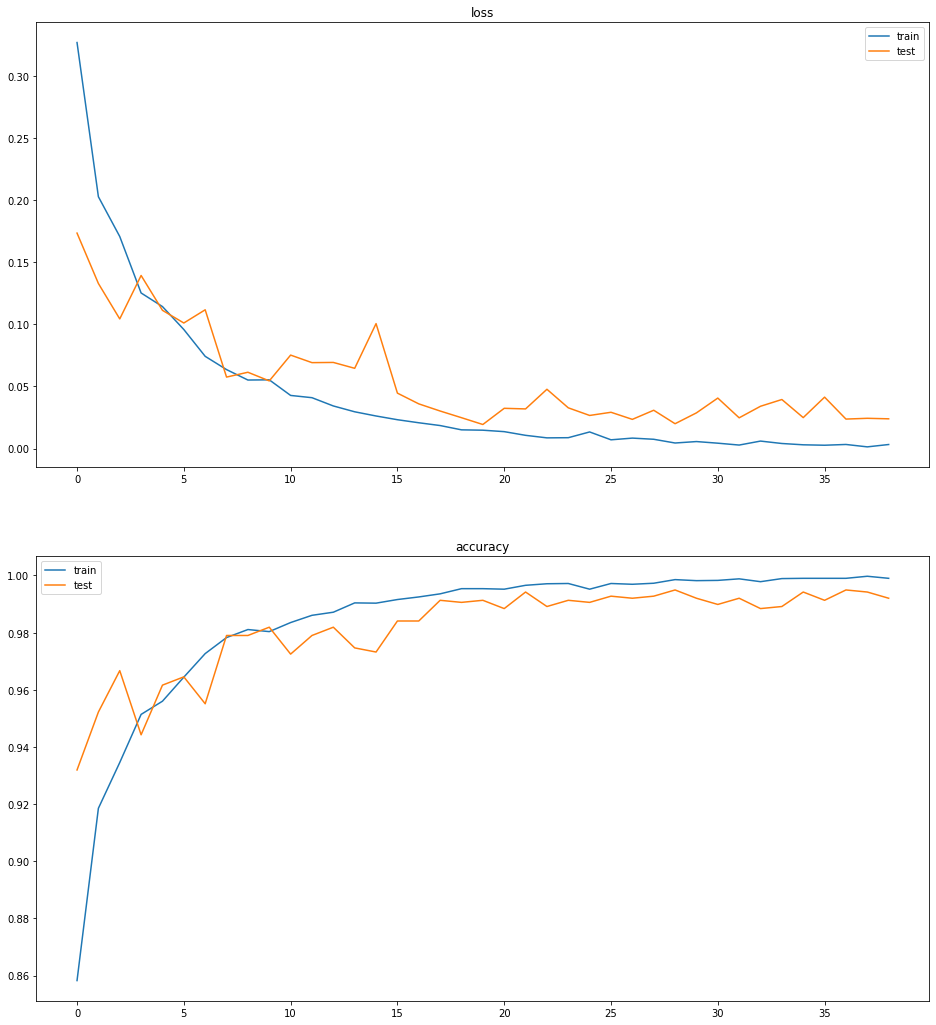

In [ ]:
plt.figure(1, figsize=(16,18))
plt.subplot(2,1,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','test'])
plt.title('loss')
plt.subplot(2,1,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','test'])
plt.title('accuracy')
plt.show()

In [ ]:
loss, acc, pre, rec = model_1.evaluate(test_generator)
print("\ntest %s: %.2f%%" % (model_1.metrics_names[1], acc * 100))
print("\ntest %s: %.2f%%" % (model_1.metrics_names[2], pre * 100))
print("\ntest %s: %.2f%%" % (model_1.metrics_names[3], rec * 100))

87/87 [==============================] - 21s 245ms/step - loss: 0.0358 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9920

test accuracy: 99.13%

test precision: 99.13%

test recall: 99.20%


# VGG_19

This is the template to add models for longer training

To use the template, fill in the blanks like before, and also change the "x" variables into integers if you want. For example, change model_x model_2 or model _3, and so on.

In [ ]:
from tensorflow.keras.applications import VGG19 

In [ ]:
base_model_x = VGG19(weights='imagenet', include_top=False) 

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
model_x = Sequential()
model_x.add(base_model_x) 
model_x.add(GlobalAveragePooling2D())
model_x.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [ ]:
model_x.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
model_x.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 20,025,410
Trainable params: 20,025,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')

model_path='/content/model_x.h5' 

checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [ ]:
hist = model_x.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[tensorboard_callback]
)

Epoch 1/50
691/691 [==============================] - 232s 280ms/step - loss: 0.5097 - accuracy: 0.7519 - precision: 0.7513 - recall: 0.7513 - val_loss: 0.4959 - val_accuracy: 0.7379 - val_precision: 0.7379 - val_recall: 0.7379

Epoch 00001: val_accuracy improved from -inf to 0.73787, saving model to /content/model_x.h5
Epoch 2/50
691/691 [==============================] - 190s 274ms/step - loss: 0.3845 - accuracy: 0.8218 - precision: 0.8199 - recall: 0.8234 - val_loss: 0.2444 - val_accuracy: 0.9037 - val_precision: 0.9038 - val_recall: 0.9044

Epoch 00002: val_accuracy improved from 0.73787 to 0.90369, saving model to /content/model_x.h5
Epoch 3/50
691/691 [==============================] - 190s 274ms/step - loss: 0.2516 - accuracy: 0.8926 - precision: 0.8929 - recall: 0.8927 - val_loss: 0.2148 - val_accuracy: 0.9175 - val_precision: 0.9180 - val_recall: 0.9160

Epoch 00003: val_accuracy improved from 0.90369 to 0.91745, saving model to /content/model_x.h5
Epoch 4/50
691/691 [========

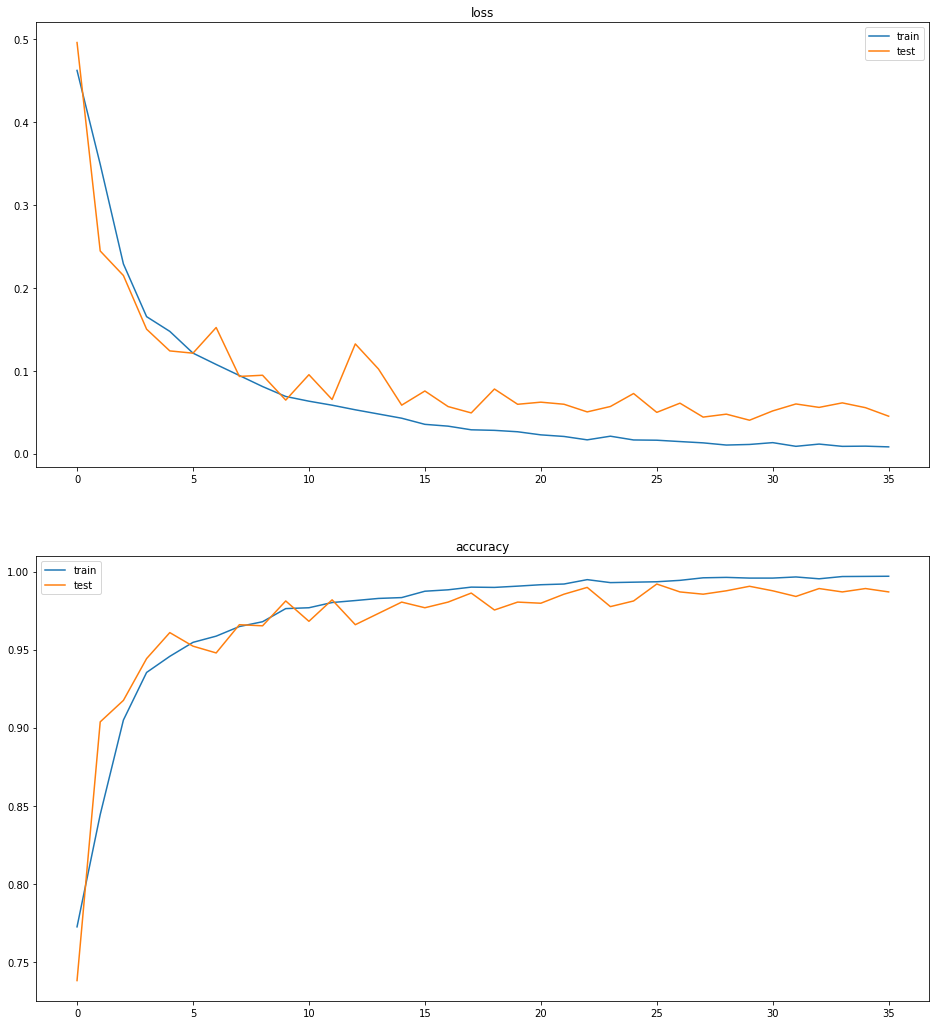

In [ ]:
plt.figure(1, figsize=(16,18))
plt.subplot(2,1,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','test'])
plt.title('loss')
plt.subplot(2,1,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','test'])
plt.title('accuracy')
plt.show()

In [ ]:
loss, acc, pre, rec = model_x.evaluate(test_generator)
print("\ntest %s: %.2f%%" % (model_x.metrics_names[1], acc * 100))
print("\ntest %s: %.2f%%" % (model_x.metrics_names[2], pre * 100))
print("\ntest %s: %.2f%%" % (model_x.metrics_names[3], rec * 100))

87/87 [==============================] - 16s 186ms/step - loss: 0.0212 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928

test accuracy: 99.28%

test precision: 99.28%

test recall: 99.28%
